# RLbook2020-The ten-armed testbed

* 2.1 A k-armed bandit porblem
* 2.2 Action-value methods
* 2.3 The 10-armed Testbed


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
# Unused

def movingaverage1(data, window_size):
    """
    扔掉卷积输出的前(window_size-1)个数据,输入与输出等长.
    The most naive method with two drawbacks:
    (1) Processing latency = window_size-1
    (2) The tail result seem a little bizzare due to lack of edge processing
    """
    window = np.ones(int(window_size))/float(window_size)
    maver = np.convolve(data, window, 'full') 
    return maver[(window_size-1):]
    

In [3]:
#a = np.array([1,2,3,4,5,6,7,8,9])
#winsize=3
#print(movingaverage1(a,winsize))

## 1. k_armed_bandit function

In [4]:
def k_armed_bandit_one_run(qstar,epsilon,nStep):
    """
    One run of K-armed bandit simulation.
    Here, K is not explicitly specified, instead it is derived from the length qstar
    """
    
    K     = len(qstar)
    Q     = np.zeros(K)                   # Estimation of action value.
    actCnt  = np.zeros(K,dtype='int')     # Record the number of action#k being selected

    a     = np.zeros(nStep+1,dtype='int') # Record the adopted action in each time step.
    r     = np.zeros(nStep+1)             # Recode the reward in each time step
    
    optAct   = np.argmax(qstar)           # The ground-truth optimal action, with the largest qstar value
    optCnt   = 0                          # Count the number of time steps in which the optimal action is selected
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1): # loop over time step
        #1. action selection
        tmp = np.random.uniform(0,1)
        #print(tmp)
        if tmp < epsilon: # random selection for exploring 
            a[t] = np.random.choice(np.arange(K))
            #print('random selection: a[{0}] = {1}'.format(t,a[t]))
        else:             # greedy selection for exploitation
            #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
            #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
            #因为np.argmax()是找第一个最大的(当存在多个同为最大时)    
            p = np.random.permutation(K)
            a[t] = p[np.argmax(Q[p])]
            #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        actCnt[a[t]] = actCnt[a[t]] + 1

        #2. reward: draw from the normal distribution with mean = qstar[a[t]], and variance = 1.
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - should be refined
        Q[a[t]] = (Q[a[t]]*(actCnt[a[t]]-1) + r[t])/actCnt[a[t]]    
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t
        
    return a,actCnt,r,Q,optRatio

## 2. The first trial

The true value $q_*(a)$ of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance.

The actual rewards were selected according to a mean $q_*(a)$, unit-variance
normal distribution

In [15]:
nStep = 10000
epsilon = 0.1
K     = 10
qstar = np.random.randn(K)
a,actCnt,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep)

qstar = 
 [ 1.21516579  0.33073445  1.18376738  0.07092504  0.17977624  2.40731134
 -0.40352898 -0.30859606 -0.57574036 -0.0660783 ]
optimal action is action#5



Text(0.5, 1.0, 'histogram of action sequence')

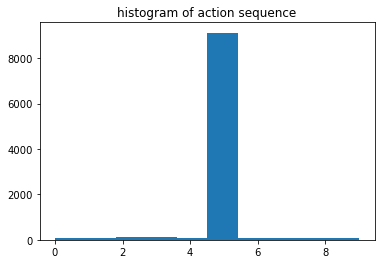

In [27]:
print('qstar = \n',qstar)
print('optimal action is action#{}\n'.format(np.argmax(qstar)))
#print('np.histogram(a) = \n ',np.histogram(a))
#print('The difference between Q and qstart = \n',Q-qstar)
fig,ax = plt.subplots()
ax.hist(a)
ax.set_title('histogram of action sequence')

### 2.1 Optimal selection ratio along the time

Text(0.5, 1.0, 'Optimal selection ratio along the time')

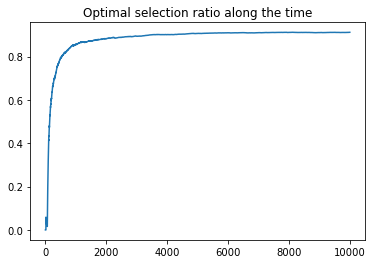

In [17]:
plt.plot(optRatio)
plt.title('Optimal selection ratio along the time')

### 2.2 Q value vs qstar

Q[k]代表所有采取行动k的reward的平均，而qstar[k]代表行动k的reward的数学期望。当$nStep\to\infty$时应该有$Q[k]\to q_*[k]$.

(-1.5, 2.0)

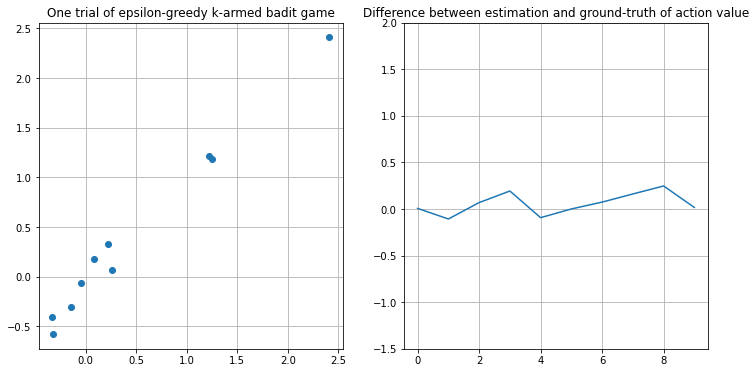

In [18]:
#plt.scatter(qstar,Q)
fig,ax = plt.subplots(1,2,figsize=[12,6])
ax[0].scatter(Q,qstar)
ax[0].grid()
ax[0].set_title('One trial of epsilon-greedy k-armed badit game')
ax[1].plot(Q-qstar)
ax[1].grid()
ax[1].set_title('Difference between estimation and ground-truth of action value')
ax[1].set_ylim(-1.5,2.0)

### 2.3 Number of actions vs qstar

actCnt[k]代表所有采取action#k被选择的次数，而qstar[k]代表action#k的reward的数学期望。当$nStep\to\infty$时理论上来说应该有reward期望越高的行动被选择的次数越多。但是与$Q[k]\propto q_*[k]$不同，各action被选择的次数应该遵循马太效应，即最后应该集中在最高q值的action或最高的几个actions上
不过从实验结果来看，并不一定是q值最高的action被选择次数最高

[  96   98  137  107   96 9119   98   81   88   80]
[ 1.21516579  0.33073445  1.18376738  0.07092504  0.17977624  2.40731134
 -0.40352898 -0.30859606 -0.57574036 -0.0660783 ]


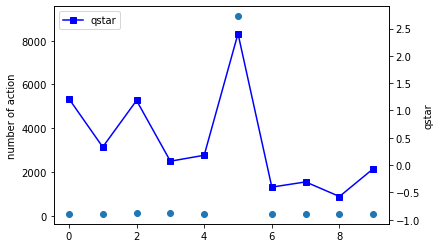

In [21]:
fig, ax2_1 = plt.subplots()
ax2_1.scatter(np.arange(K),actCnt)
ax2_1.set_ylabel("number of action")

ax2_2 = ax2_1.twinx()
ax2_2.plot(np.arange(K),qstar, label='qstar', color='blue', marker='s')
ax2_2.set_ylabel("qstar")
ax2_2.set_ylim(np.min(qstar)-0.5, np.max(qstar)+0.5)
ax2_2.legend(loc='upper left')
print(actCnt)
print(qstar)

## 3. Comparison between different epsilon

单次的run的结果有较大的随机性，要比较不同的epsilon条件下的算法行为，需要做蒙特卡洛仿真。针对某个epsilon参数设定，在随机条件下执行多次仿真，然后将多次仿真的结果进行统计平均，得到统计平均行为。然后针对不同epsilon充分以上步骤，最后比较不同epsilon设定下的统计平均行为。

* 仿真控制参数
    * number of steps
    * number of run
    * K: The number of candidate actions    
* Input:
    * qstar[K]
    * epsilon: greedy factor $\epsilon$
* Output:
    * a[t]: action series for each step in one run
    * r[t]: reward series for each step in one run
    * Q[k]: reward sample average up to t-1 for action[k].
Note!!!: qstar randonmization should be put inside the outer loop to make each run representing a different bandit problem.

In [10]:
nStep = 1000
nRun  = 2000
#qstar   = np.random.randn(10) 

r_0p0   = np.zeros((nRun,nStep+1))
r_0p1   = np.zeros((nRun,nStep+1))
r_0p01  = np.zeros((nRun,nStep+1))
optRatio_0p0 = np.zeros((nRun,nStep+1))
optRatio_0p1 = np.zeros((nRun,nStep+1))
optRatio_0p01= np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10) 
    a,aNum,r_0p0[run,:],Q,optRatio_0p0[run,:] = k_armed_bandit_one_run(qstar,epsilon=0,nStep=nStep)
    a,aNum,r_0p1[run,:],Q,optRatio_0p1[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep)
    a,aNum,r_0p01[run,:],Q,optRatio_0p01[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.01,nStep=nStep)


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

### 3.1 Average Reward

首先我们定义一个smooth函数，用于对仿真结果进行一个统计平均，使得结果看起来更“好看”一些。

In [23]:
def smooth(a,winsize):
    """
    Smoothing with edge processing.
    Input:
        a:原始数据，NumPy 1-D array containing the data to be smoothed,必须是1-D的，如果不是，请使用 np.ravel()或者np.squeeze()转化 
        winsize: smoothing window size needs, which must be odd number,as in the original MATLAB implementation
    Output:
        
    """
    out0 = np.convolve(a,np.ones(winsize,dtype=int),'valid')/winsize
    r = np.arange(1,winsize-1,2)
    start = np.cumsum(a[:winsize-1])[::2]/r
    stop = (np.cumsum(a[:-winsize:-1])[::2]/r)[::-1]
    return np.concatenate(( start , out0, stop ))

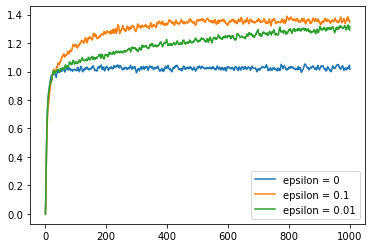

In [24]:
rEnsembleMean_0p0 = np.mean(r_0p0,axis=0)
rEnsembleMean_0p1 = np.mean(r_0p1,axis=0)
rEnsembleMean_0p01 = np.mean(r_0p01,axis=0)
#plt.plot(rEnsembleMean)
plt.plot(smooth(rEnsembleMean_0p0,5))
plt.plot(smooth(rEnsembleMean_0p1,5))
plt.plot(smooth(rEnsembleMean_0p01,5))
plt.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

### 3.2 Optimal Action
Optimal Action是指对应于$q_*$中期望值最高的那个。In the above simulation, $q_*$ is re-initialized for each run. Hence, in simulation, the optimal action counting must be tracked in each run in a cumulative way.

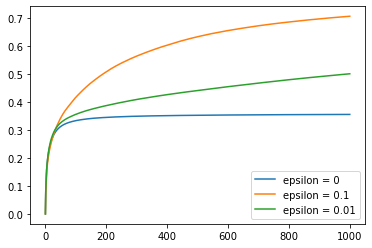

In [25]:
optRatioEnsembleMean_0p0 = np.mean(optRatio_0p0,axis=0)
optRatioEnsembleMean_0p1 = np.mean(optRatio_0p1,axis=0)
optRatioEnsembleMean_0p01 = np.mean(optRatio_0p01,axis=0)
#plt.plot(rEnsembleMean)
plt.plot(smooth(optRatioEnsembleMean_0p0,5))
plt.plot(smooth(optRatioEnsembleMean_0p1,5))
plt.plot(smooth(optRatioEnsembleMean_0p01,5))
plt.legend(['epsilon = 0','epsilon = 0.1','epsilon = 0.01'])

## 4 Summary
上图结果与书中的Figure2.2基本是一致的(就相对关系以及变化趋势而言，具体的收敛值有一定差异)。
In case of epsilon=0, the convergence value=1.0, is this an inevitable result, for example, can be derived mathematically under the assumption?